# Enhanced Vegetation Index (EVI)

The Enhanced Vegetation Index (EVI) is an optimized vegetation index designed to enhance the vegetation signal with improved sensitivity in high biomass regions. It was developed as an alternative to NDVI to correct for some atmospheric influences and canopy background signals.

## Key Features of EVI:
- Range: -1 to +1 (like NDVI)
- More sensitive to variations in dense vegetation
- Reduces atmospheric influences
- Corrects for canopy background signals

### EVI Formula:
```
EVI = G * ((NIR - RED) / (NIR + C1 * RED - C2 * BLUE + L))
```
where:
- G = 2.5 (gain factor)
- C1 = 6 (atmospheric resistance red coefficient)
- C2 = 7.5 (atmospheric resistance blue coefficient)
- L = 1 (canopy background adjustment)
- NIR = Near-infrared reflectance
- RED = Red reflectance
- BLUE = Blue reflectance

## Import Required Libraries

We begin by importing the necessary Python libraries for data processing and visualization.

In [11]:
import matplotlib.pyplot as plt
import rasterio
import openeo
from matplotlib.colors import LinearSegmentedColormap

## Connect to OpenEO Backend

Connect to the OpenEO backend service which provides access to Sentinel-2 satellite imagery.

In [12]:
# Connect to the OpenEO backend and authenticate
# connection = openeo.connect(
#     url="https://openeo.ds.io"
# ).authenticate_oidc_authorization_code()

connection = openeo.connect(
    url="http://127.0.0.1:8081/"
).authenticate_oidc_authorization_code()

## Set Up Data Collection

We'll use Sentinel-2 Level 2A data, which provides surface reflectance values. The area of interest is in the South Tyrol region of Italy.

Required bands:
- B02 (Blue): 490nm
- B04 (Red): 665nm
- B08 (NIR): 842nm

In [13]:
# Define data collection parameters
collection_id = "sentinel-2-l2a"

# Define spatial extent (South Tyrol, Italy)
spat_ext = {"west": 11.27, "east": 11.40, "south": 46.46, "north": 46.52}

# Define time range (June 2018)
time_range = ["2018-06-04", "2018-06-10"]

# Select required bands
bands = ["B08_10m", "B04_10m", "B02_10m"]

# Create datacube
s2 = connection.datacube_from_process(
    "load_collection",
    id=collection_id,
    spatial_extent=spat_ext,
    temporal_extent=time_range,
    bands=bands,
    width=None,
)

## Compute EVI

Now we'll calculate the EVI using the formula:
EVI = 2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))

The resulting index values will range from -1 to +1, where:
- Higher values (0.4-0.9): Dense vegetation
- Medium values (0.2-0.4): Moderate vegetation
- Lower values (<0.2): Sparse or no vegetation
- Negative values: Usually water, snow, or clouds

In [14]:
# Extract individual bands
b02 = s2.band(2).divide(10000)  # Blue
b04 = s2.band(1).divide(10000)  # Red
b08 = s2.band(0).divide(10000)  # NIR

# Calculate EVI
evi = 2.5 * ((b08 - b04) / (b08 + 6 * b04 - 7.5 * b02 + 1))

# Get minimum EVI value over time period
min_evi = evi.min_time()

# Save result
output = min_evi.download("evi.tif", format="GTiff", options={"compress": "DEFLATE"})

Preflight process graph validation failed: [400] InvalidRequest: 1 validation error:
  {'type': 'missing', 'loc': ('body', 'id'), 'msg': 'Field required', 'input': {'process_graph': {'loadcollection1': {'process_id': 'load_collection', 'arguments': {'bands': ['B08_10m', 'B04_10m', 'B02_10m'], 'id': 'sentinel-2-l2a', 'spatial_extent': {'west': 11.27, 'east': 11.4, 'south': 46.46, 'north': 46.52}, 'temporal_extent': ['2018-06-04', '2018-06-10'], 'width': None}}, 'reducedimension1': {'process_id': 'reduce_dimension', 'arguments': {'data': {'from_node': 'loadcollection1'}, 'dimension': 'bands', 'reducer': {'process_graph': {'arrayelement1': {'process_id': 'array_element', 'arguments': {'data': {'from_parameter': 'data'}, 'index': 0}}, 'divide1': {'process_id': 'divide', 'arguments': {'x': {'from_node': 'arrayelement1'}, 'y': 10000}}, 'arrayelement2': {'process_id': 'array_element', 'arguments': {'data': {'from_parameter': 'data'}, 'index': 1}}, 'divide2': {'process_id': 'divide', 'argument

## Visualize EVI Results

Let's create a visualization of the EVI results using a green color scale. The color scheme will help interpret vegetation density, with darker greens representing higher EVI values.

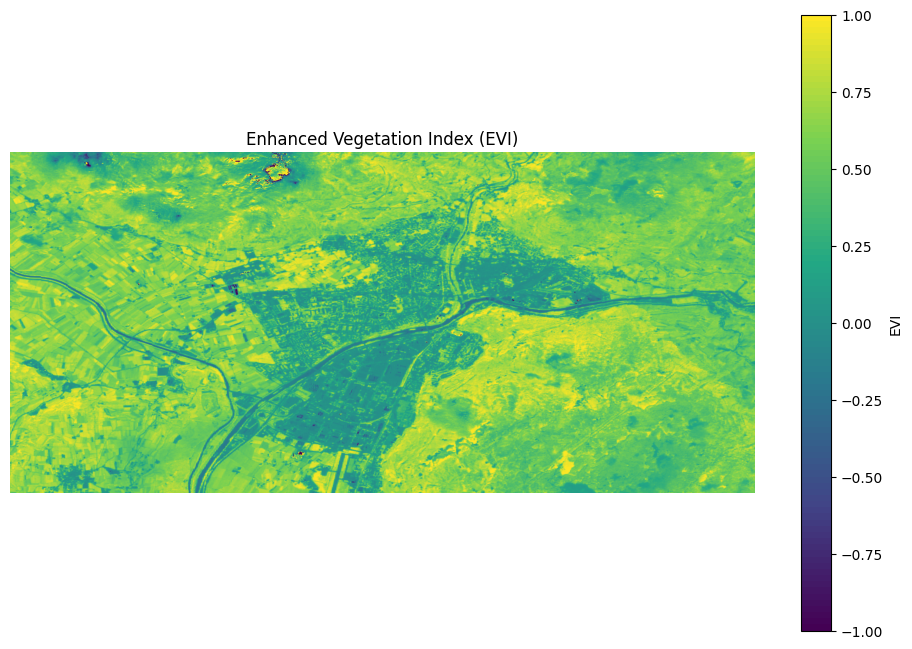

In [15]:
# Read the saved GeoTIFF file
with rasterio.open("evi.tif") as src:
    evi_data = src.read(1)

# Create custom colormap for EVI
colors = ["#440154", "#414487", "#2a788e", "#22a884", "#7ad151", "#fde725"]
n_bins = 100
cmap = LinearSegmentedColormap.from_list("custom_evi", colors, N=n_bins)

# Create figure
plt.figure(figsize=(12, 8))
im = plt.imshow(evi_data, cmap=cmap, vmin=-1, vmax=1)
plt.colorbar(im, label="EVI")
plt.title("Enhanced Vegetation Index (EVI)")
plt.axis("off")
plt.show()

## Interpreting the Results

The visualization shows EVI values across the study area where:

- Yellow/Light green (0.4 to 1.0): Areas of dense, healthy vegetation
- Medium green (0.2 to 0.4): Areas with moderate vegetation cover
- Blue/Purple (-1.0 to 0.2): Areas with sparse vegetation, bare soil, or water

The EVI is particularly useful for:
1. Monitoring vegetation health and density
2. Detecting seasonal changes in vegetation
3. Identifying agricultural areas and forest cover
4. Assessing biomass and crop conditions